# Polyhedral Compiler Hands-on with Caten


This tutorial demonstrates how to use `caten.polyhedral` to construct and transform schedules for high-performance kernels, including Matrix Multiplication optimization and Conv-Pool Fusion.


## 1. Setup


In [45]:
import sys
sys.path.append("../")

import caten.isl as I
import caten.polyhedral as P

print("Caten initialized.")

Caten initialized.


## 2. Gemm Optimization

Repro of this article
https://salykova.github.io/matmul-cpu

ScheduleNodeDomain(
    ┏ [domain] (M, N, K)
    ┗  WMMA[i, j, k] : 0 ≤ i < M ∧ 0 ≤ j < N ∧ 0 ≤ k < K
      ┏ [band]
      ┃  WMMA[i, j, k] → i
      ┃  WMMA[i, j, k] → j
      ┗  WMMA[i, j, k] → k
        ┗ [leaf]
)
for (int c0 = 0; c0 < M; c0 += 1)
  for (int c1 = 0; c1 < N; c1 += 1)
    for (int c2 = 0; c2 < K; c2 += 1)
      assign(C[c1][c0], C[c1][c0] + A[c2][c0] * B[c1][c2]);



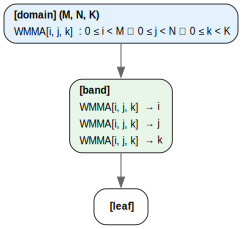

In [49]:
def create_gemm_schedule():
    A, B, C = map(I.expr, ("A", "B", "C"))
    zero = I.expr(0)

    with P.parameter("M, N, K"):
        with P.domain("{ WMMA[i,j,k] : 0<=i<M and 0<=j<N and 0<=k<K }") as gemm:
            with P.band("{ WMMA[i,j,k] -> [i, j, k] }"):
                P.stmt("C[j,i] = C[j,i], A[k,i], B[j,k]")[
                    lambda i, j, k: C[j, i].assign(C[j, i] + A[k, i] * B[j, k])
                ]
    return gemm

print(create_gemm_schedule())
print(create_gemm_schedule().to_c())
create_gemm_schedule().viz()

In [48]:
with create_gemm_schedule().editor() as gemm:
    gemm = gemm.domain()
    with gemm.band()["ijk -> ikj"] as gemm: # interchange
        gemm = gemm @ P.Parallel(128, 128, 128)
        gemm = gemm << P.Prefetch("A", 1, 8)
        gemm = gemm << P.prefetch("B", 8, 1)
        gemm = gemm @ P.TensorCore(8, 8, 8, reminder="padding")

AttributeError: 'domain' object has no attribute 'domain'

## 3. Conv2D+Pool2D On-the-fly reduction

Conv2D

Pool2D

In [19]:
def create_conv_schedule():
    out, inp, wei = map(I.expr, ("Out", "In", "W"))
    zero = I.expr(0)
    with P.parameter("N, K_out, H_out, W_out, Cin, KH, KW"):
        d1 = P.domain("{ S_conv_init[n,k,h,w] : 0<=n<N and 0<=k<K_out and 0<=h<H_out and 0<=w<W_out }")
        d2 = P.domain("{ S_conv[n,k,h,w,c,kh,kw] : "
                     "0<=n<N and 0<=k<K_out and 0<=h<H_out and 0<=w<W_out and "
                     "0<=c<Cin and 0<=kh<KH and 0<=kw<KW }")
        with (d1 | d2) as conv:
            with P.filter("{ S_conv_init[n,k,h,w] }"):
                with P.band("{ S_conv_init[n,k,h,w] -> [n, k, h, w] }"):
                    P.stmt("Out[n,k,h,w] = 0")[lambda n, k, h, w: out[n, k, h, w].assign(zero)]
            with P.filter("{ S_conv[n,k,h,w,c,kh,kw] }"):
                with P.band("{ S_conv[n,k,h,w,c,kh,kw] -> [n, k, h, w, c, kh, kw] }"):
                    P.stmt("Out[n,k,h,w] = Out[n,k,h,w], In[n,c,h+kh,w+kw], W[k,c,kh,kw]")[
                        lambda n, k, h, w, c, kh, kw: out[n, k, h, w].assign(out[n, k, h, w] + inp[n, c, h + kh, w + kw] * wei[k, c, kh, kw])]
    return conv

def create_pool_schedule():
    S_pool = I.expr(2)
    pool_buf, out = map(I.expr, ("PoolBuf", "Out"))
    neg_inf = I.expr(0) # TODO: This should be negative inf
    with P.parameter("N, K_out, H_pool, W_pool, KH_pool, KW_pool, H_out, W_out"):
        d1 = P.domain(
            "{ S_pool_init[n,k,h,w] : 0<=n<N and 0<=k<K_out and 0<=h<H_pool and 0<=w<W_pool }"
        )
        d2 = P.domain(
            "{ S_pool[n,k,h,w,rh,rw] : "
            "0<=n<N and 0<=k<K_out and 0<=h<H_pool and 0<=w<W_pool and "
            "0<=rh<KH_pool and 0<=rw<KW_pool }"
        )
        with (d1 | d2) as pool:
            with P.filter("{ S_pool_init[n,k,h,w] }"):
                with P.band("{ S_pool_init[n,k,h,w] -> [n, k, h, w] }"):
                    P.stmt("PoolBuf[n,k,h,w] = -INF")[
                        lambda n, k, h, w:
                            pool_buf[n, k, h, w].assign(neg_inf)
                    ]
            # reduction
            with P.filter("{ S_pool[n,k,h,w,rh,rw] }"):
                with P.band("{ S_pool[n,k,h,w,rh,rw] -> [n, k, h, w, rh, rw] }"):
                    P.stmt("PoolBuf[n,k,h,w] = PoolBuf[n,k,h,w], Out[n,k,h*2+rh,w*2+rw]")[
                        lambda n, k, h, w, rh, rw:
                            pool_buf[n, k, h, w].assign(
                                pool_buf[n, k, h, w].max(
                                    out[n, k, h * S_pool + rh, w * S_pool + rw]
                                )
                            )
                    ]
    return pool

ScheduleNodeDomain(
    ┏ [domain] (N, K_out, H_out, W_out, Cin, KH, KW)
    ┃  S_conv[n, k, h, w, c, kh, kw] : 0 ≤ n < N ∧ 0 ≤ k < K_out ∧ 0 ≤ h < H_out ∧ 0 ≤ w < W_out ∧ 0 ≤ c < Cin ∧ 0 ≤ kh < KH ∧ 0 ≤ kw < KW
    ┗  S_conv_init[n, k, h, w]       : 0 ≤ n < N ∧ 0 ≤ k < K_out ∧ 0 ≤ h < H_out ∧ 0 ≤ w < W_out
      ┗ [sequence]
        ┏ [filter]
        ┗  S_conv_init[n, k, h, w]
          ┏ [band]
          ┃  S_conv_init[n, k, h, w] → n
          ┃  S_conv_init[n, k, h, w] → k
          ┃  S_conv_init[n, k, h, w] → h
          ┗  S_conv_init[n, k, h, w] → w
            ┗ [leaf]
        ┏ [filter]
        ┗  S_conv[n, k, h, w, c, kh, kw]
          ┏ [band]
          ┃  S_conv[n, k, h, w, c, kh, kw] → n
          ┃  S_conv[n, k, h, w, c, kh, kw] → k
          ┃  S_conv[n, k, h, w, c, kh, kw] → h
          ┃  S_conv[n, k, h, w, c, kh, kw] → w
          ┃  S_conv[n, k, h, w, c, kh, kw] → c
          ┃  S_conv[n, k, h, w, c, kh, kw] → kh
          ┗  S_conv[n, k, h, w, c, kh, kw] → kw
    

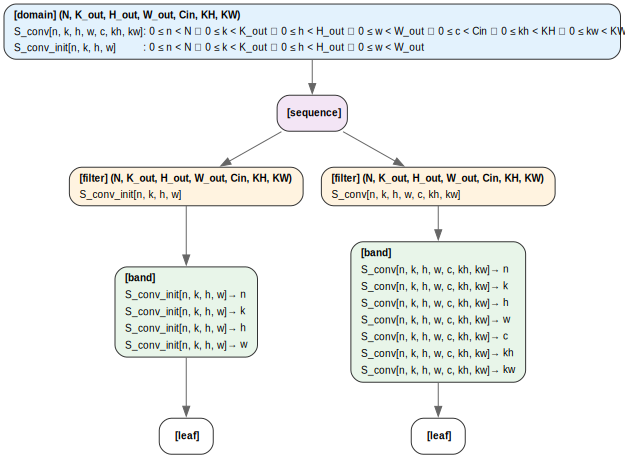

In [20]:
print(create_conv_schedule())
create_conv_schedule().viz()

ScheduleNodeDomain(
    ┏ [domain] (N, K_out, H_pool, W_pool, KH_pool, KW_pool, H_out, W_out)
    ┃  S_pool_init[n, k, h, w]    : 0 ≤ n < N ∧ 0 ≤ k < K_out ∧ 0 ≤ h < H_pool ∧ 0 ≤ w < W_pool
    ┗  S_pool[n, k, h, w, rh, rw] : 0 ≤ n < N ∧ 0 ≤ k < K_out ∧ 0 ≤ h < H_pool ∧ 0 ≤ w < W_pool ∧ 0 ≤ rh < KH_pool ∧ 0 ≤ rw < KW_pool
      ┗ [sequence]
        ┏ [filter]
        ┗  S_pool_init[n, k, h, w]
          ┏ [band]
          ┃  S_pool_init[n, k, h, w] → n
          ┃  S_pool_init[n, k, h, w] → k
          ┃  S_pool_init[n, k, h, w] → h
          ┗  S_pool_init[n, k, h, w] → w
            ┗ [leaf]
        ┏ [filter]
        ┗  S_pool[n, k, h, w, rh, rw]
          ┏ [band]
          ┃  S_pool[n, k, h, w, rh, rw] → n
          ┃  S_pool[n, k, h, w, rh, rw] → k
          ┃  S_pool[n, k, h, w, rh, rw] → h
          ┃  S_pool[n, k, h, w, rh, rw] → w
          ┃  S_pool[n, k, h, w, rh, rw] → rh
          ┗  S_pool[n, k, h, w, rh, rw] → rw
            ┗ [leaf]
)


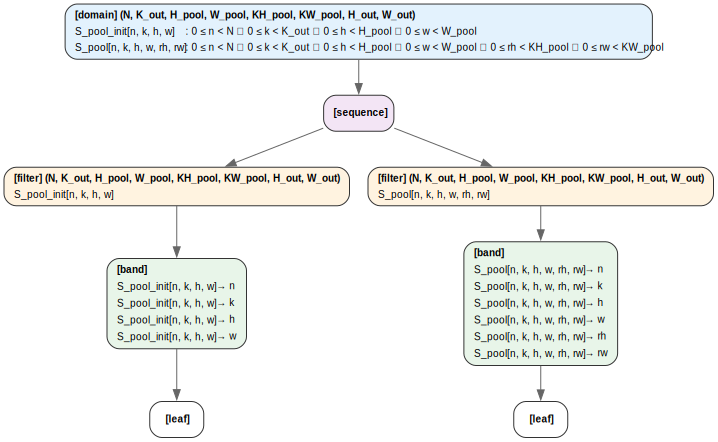

In [21]:
print(create_pool_schedule())
create_pool_schedule().viz()

In [40]:
with P.sequence(conv, pool) as seq:
    # todo: get reshape/permute parameter from conv/pool access rel
    with seq[0].permute(0, 1, 2, 3) as conv_band:
        pass
    with (seq[1] @ [1, 1, 4, 1]).permute(0, 1, 2, 3) as pool_band:
        pass
    seq = seq.fuse()
    # coalesce
    with (seq << P.Parallel()) as inner:
        tensor_core = (inner @ P.TensorCore(4, 4))

# conv+pool fusion and optimization
with (conv + pool) as sequence:
    # any idea?

# matmul
gemm = gemm_kernel()
with (gemm.permute("ijk -> ikj")).maximize_band_depth() as gemm:
    gemm_128x128x128 = gemm @ P.Parallel(128, 128, 128)
    gemm_64x64x128 = gemm << P.Prefetch(64, 64) # this will sunk, e.g.: mapped w/ pack_block_A, pack_block_B
    with (gemm @ P.TensorCore(8, 8, 8)) as gemm_tc, gemm_reminder:
        gemm_tc
        with (gemm_reminder @ P.Vectorize(8, 8)) as gemm_vec, gemm_rem:
            gemm_vec
        
print(gemm) # baseline
print(gemm_8x8x8) # optimized ver

# softmax
softmax = softmax_kernel()
with softmax @ P.Parallel(Local1, Local2) as ...:
    # any idea?
    pass

IndentationError: expected an indented block after 'with' statement on line 13 (1333366227.py, line 17)

 ## Softmax Optimization

In [16]:
def create_softmax_schedule():
    logits, prob, tmp, maxv, sumv = map(I.expr, ("Out", "Prob", "Tmp", "Max", "Sum"))
    neg_inf, zero = I.expr(0), I.expr(0)
    exp = getattr(I, "exp", None)
    with P.parameter("N, K_out, H_out, W_out"):
        d0 = P.domain("{ S_sm_init_max[n,h,w] : 0<=n<N and 0<=h<H_out and 0<=w<W_out }")
        d1 = P.domain("{ S_sm_max[n,h,w,k] : 0<=n<N and 0<=h<H_out and 0<=w<W_out and 0<=k<K_out }")
        d2 = P.domain("{ S_sm_init_sum[n,h,w] : 0<=n<N and 0<=h<H_out and 0<=w<W_out }")
        d3 = P.domain("{ S_sm_exp_sum[n,h,w,k] : 0<=n<N and 0<=h<H_out and 0<=w<W_out and 0<=k<K_out }")
        d4 = P.domain("{ S_sm_norm[n,h,w,k] : 0<=n<N and 0<=h<H_out and 0<=w<W_out and 0<=k<K_out }")
        with (d0 | d1 | d2 | d3 | d4) as sm:
            # init max
            with P.filter("{ S_sm_init_max[n,h,w] }"):
                with P.band("{ S_sm_init_max[n,h,w] -> [n, h, w, 0] }"):
                    P.stmt("Max[n,h,w] = 0")[
                        lambda n, h, w:
                            maxv[n, h, w].assign(neg_inf)
                    ]
            # max reduce
            with P.filter("{ S_sm_max[n,h,w,k] }"):
                with P.band("{ S_sm_max[n,h,w,k] -> [n, h, w, 1, k] }"):
                    P.stmt("Max[n,h,w] = Max[n,h,w], Out[n,k,h,w]")[
                        lambda n, h, w, k:
                            maxv[n, h, w].assign(
                                maxv[n, h, w].max(logits[n, k, h, w])
                            )
                    ]

            # init sum
            with P.filter("{ S_sm_init_sum[n,h,w] }"):
                with P.band("{ S_sm_init_sum[n,h,w] -> [n, h, w, 2] }"):
                    P.stmt("Sum[n,h,w] = 0")[
                        lambda n, h, w:
                            sumv[n, h, w].assign(zero)
                    ]

            # exp + sum reduce (and materialize tmp)
            with P.filter("{ S_sm_exp_sum[n,h,w,k] }"):
                with P.band("{ S_sm_exp_sum[n,h,w,k] -> [n, h, w, 3, k] }"):
                    P.stmt("Tmp[n,k,h,w] = Out[n,k,h,w], Max[n,h,w]; Sum[n,h,w] = Sum[n,h,w], Tmp[n,k,h,w]")[
                        lambda n, h, w, k:
                            (
                                tmp[n, k, h, w].assign(
                                    exp(logits[n, k, h, w] - maxv[n, h, w]) if exp is not None
                                    else (logits[n, k, h, w] - maxv[n, h, w]).exp()
                                ),
                                sumv[n, h, w].assign(
                                    sumv[n, h, w] + tmp[n, k, h, w]
                                )
                            )
                    ]

            # normalize
            with P.filter("{ S_sm_norm[n,h,w,k] }"):
                with P.band("{ S_sm_norm[n,h,w,k] -> [n, h, w, 4, k] }"):
                    P.stmt("Prob[n,k,h,w] = Tmp[n,k,h,w], Sum[n,h,w]")[
                        lambda n, h, w, k:
                            prob[n, k, h, w].assign(
                                tmp[n, k, h, w] / sumv[n, h, w]
                            )
                    ]

    return sm

In [17]:
create_softmax_schedule()

isl_schedule_node.c:2832: cannot delete child of set or sequence


ISLError: cannot delete child of set or sequence | isl_schedule_node.c:2832